<a href="https://colab.research.google.com/github/kojomensahonums/GSOC24_ML4SCI/blob/master/Lens_finding_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import glob
from PIL import Image
from multiprocessing import Pool
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

### Accesssing image directories

In [3]:
# Use 80% for train and 20% for validation test
# At the end of the pipeline use all of the hard dataset to evaluate-test the model

os.getcwd()
train_dir = r'/content/drive/Othercomputers/My laptop/GSOC_24/ML4SCI/Lens_Finding/Easy_Band2/Band2'
df_train = pd.read_csv("/content/drive/Othercomputers/My laptop/GSOC_24/ML4SCI/Lens_Finding/Easy_Band2/easy_Band2.csv")
df_train['Class'] = df_train['Class'].astype(str)
df_train.head()

test_dir = r'/content/drive/Othercomputers/My laptop/GSOC_24/ML4SCI/Lens_Finding/Hard_Band2/Band2'
df_test = pd.read_csv("/content/drive/Othercomputers/My laptop/GSOC_24/ML4SCI/Lens_Finding/Hard_Band2/hard_Band2.csv")
df_test['Class'] = df_test['Class'].astype(str)
df_test.head()

,ID,Class,numb_pix_lensed_image
0,imageSDSS_I-100006.png,0,417
1,imageSDSS_I-100012.png,0,407
2,imageSDSS_I-100020.png,0,470
3,imageSDSS_I-100028.png,0,438
4,imageSDSS_I-100039.png,1,0


### Visualising dataset samples

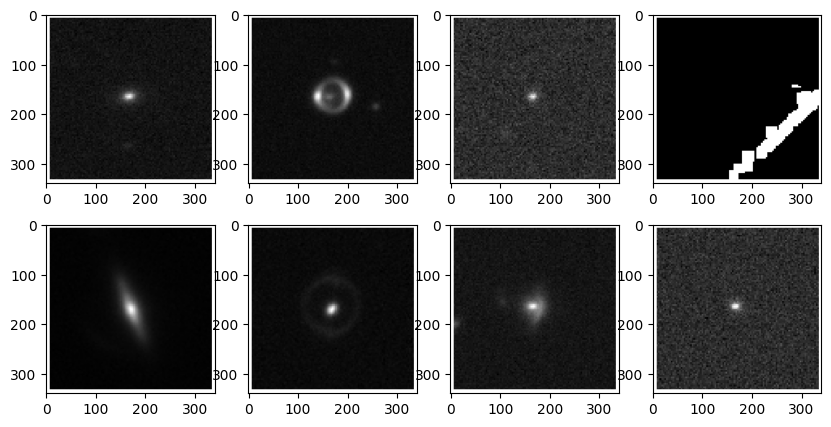

In [4]:
%matplotlib inline

src_path = train_dir
sub_class = os.listdir(src_path)

fig = plt.figure(figsize=(10,5))
for e in range(len(sub_class[:8])):
    plt.subplot(2,4,e+1)
    img = plt.imread(os.path.join(src_path,sub_class[e]))
    plt.imshow(img, cmap=plt.get_cmap('gray'))

### Data Handling (Augmentation, Rescaling, Splitting)

Train generator holds 80% of the training data for training. <br>
Valid generator holds 20% of the training data for evaluation during training. <br>
Test generator holds the entire test set for evaluation after training.

In [5]:
train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20)

test_datagen = ImageDataGenerator(rescale=1 / 255.0)#, validation_split=0.50)

In [6]:
batch_size = 32
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=train_dir,
    x_col="ID",
    y_col="Class",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)
valid_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=train_dir,
    x_col="ID",
    y_col="Class",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="categorical",
    subset='validation',
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=test_dir,
    x_col="ID",
    y_col="Class", # comment out
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical", # change to None
    #subset='validation', # comment out
    shuffle=False,
    seed=42
)

Found 9600 validated image filenames belonging to 2 classes.
Found 2400 validated image filenames belonging to 2 classes.
Found 2600 validated image filenames belonging to 2 classes.


#### Model Building

Building from scratch a VGG-16 model using its model architecture

In [7]:
model = Sequential()

model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

# Fully connected layers
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=2, activation="softmax"))

In [8]:
METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

# Define optimizer
opt = Adam(learning_rate=0.001)

model.compile(loss=tf.losses.CategoricalCrossentropy(), optimizer=opt, metrics=METRICS)
# Observe
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                   

### Train model

In [11]:
logdir = r"/content/drive/Othercomputers/My laptop/GSOC_24/ML4SCI/Lens_Finding/Logs"
tensorboard_callback = TensorBoard(log_dir=logdir)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, mode='auto')

# change no. of epochs

hist = model.fit(train_generator,
                    validation_data = valid_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_steps = valid_generator.n//valid_generator.batch_size,
                    epochs=100,
                    callbacks=[early, tensorboard_callback])

Epoch 1/100
300/300 [==============================] - 609s 2s/step - loss: 0.7041 - accuracy: 0.5041 - precision: 0.5041 - recall: 0.5041 - val_loss: 0.6933 - val_accuracy: 0.4971 - val_precision: 0.4971 - val_recall: 0.4971
Epoch 2/100
300/300 [==============================] - 251s 835ms/step - loss: 0.6932 - accuracy: 0.5007 - precision: 0.5007 - recall: 0.5007 - val_loss: 0.6932 - val_accuracy: 0.4971 - val_precision: 0.4971 - val_recall: 0.4971
Epoch 3/100
300/300 [==============================] - 250s 833ms/step - loss: 0.6933 - accuracy: 0.4945 - precision: 0.4945 - recall: 0.4945 - val_loss: 0.6932 - val_accuracy: 0.4971 - val_precision: 0.4971 - val_recall: 0.4971
Epoch 4/100
300/300 [==============================] - 255s 851ms/step - loss: 0.6932 - accuracy: 0.4968 - precision: 0.4968 - recall: 0.4968 - val_loss: 0.6932 - val_accuracy: 0.4971 - val_precision: 0.4971 - val_recall: 0.4971
Epoch 5/100
300/300 [==============================] - 291s 970ms/step - loss: 0.6932 -

### Save model

In [13]:
model.save(os.path.join(r"/content/drive/Othercomputers/My laptop/GSOC_24/ML4SCI/Lens_Finding/Models", 'lens_finding_baseline.h5'))


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Evaluate Performance on Validation Set

In [15]:
score = model.evaluate(valid_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

75/75 [==============================] - 46s 608ms/step - loss: 0.6932 - accuracy: 0.4971 - precision: 0.4971 - recall: 0.4971
Test loss: 0.6932212114334106
Test accuracy: 0.4970833361148834


Plots of metrics

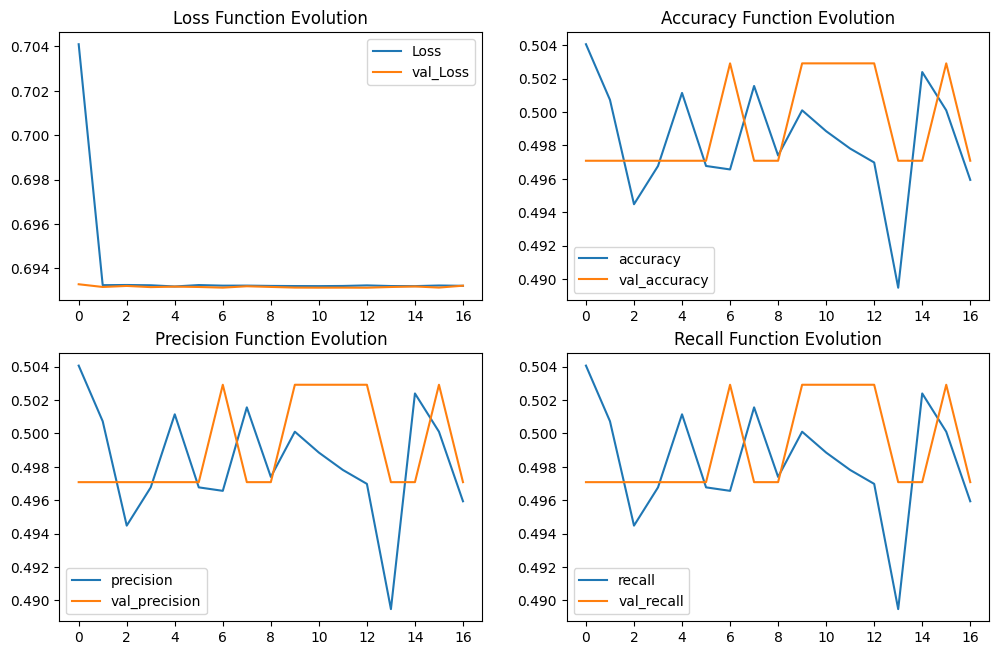

In [16]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(hist.history['loss'], label='Loss')
plt.plot(hist.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(hist.history['precision'], label='precision')
plt.plot(hist.history['val_precision'], label='val_precision')
plt.title('Precision Function Evolution')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(hist.history['recall'], label='recall')
plt.plot(hist.history['val_recall'], label='val_recall')
plt.title('Recall Function Evolution')
plt.legend()

ROC Curve and AUC Score

75/75 [==============================] - 41s 550ms/step


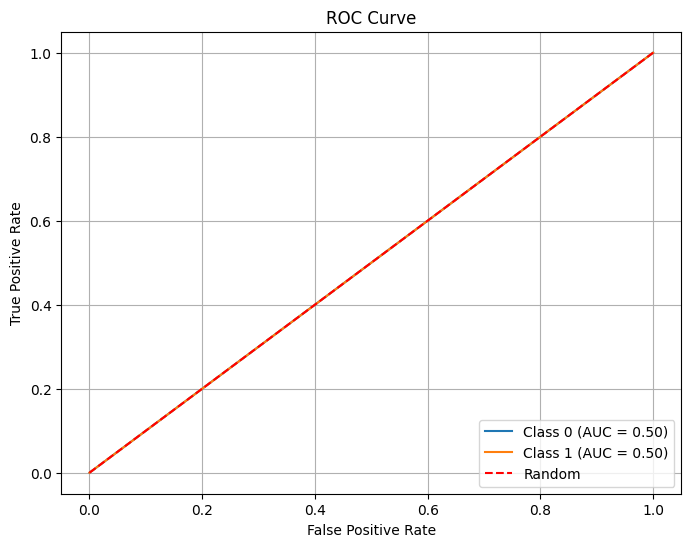

In [17]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Step 1: Generate predictions on the validation or test set
# Assuming your model is named 'model' and you want to evaluate on the validation set
predictions = model.predict(valid_generator)

# Step 2: Extract true labels from the validation generator
true_labels = valid_generator.classes

# Step 3: Compute the ROC curve and AUC score for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(valid_generator.class_indices)):
    fpr[i], tpr[i], _ = roc_curve(true_labels, predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 4: Plot the ROC curve for each class along with the AUC score
plt.figure(figsize=(8, 6))
for i in range(len(valid_generator.class_indices)):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### Evaluate Performance on Test Set

In [19]:
predict=model.predict(test_generator, steps = len(test_generator.filenames))
y_classes = predict.argmax(axis=-1)
print(y_classes)

  82/2600 [..............................] - ETA: 9:00:57

2600/2600 [==============================] - 1044s 402ms/step
[0 0 0 ... 0 0 0]


82/82 [==============================] - 18s 223ms/step


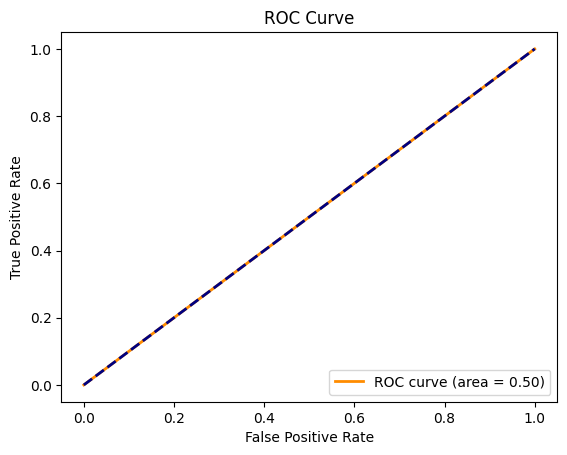

ROC AUC Score: 0.5


In [20]:
# Step 1: Generate predictions on the test set
predictions = model.predict(test_generator)

# Step 2: Compute the predicted probabilities for each class
predicted_probabilities = predictions[:, 1]  # Assuming binary classification, adjust if necessary

# Step 3: Compute the ROC AUC curve and score
from sklearn.metrics import roc_curve, roc_auc_score

true_labels = test_generator.classes
fpr, tpr, _ = roc_curve(true_labels, predicted_probabilities)
roc_auc = roc_auc_score(true_labels, predicted_probabilities)

# Step 4: Plot the ROC curve
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Step 5: Print the ROC AUC score
print("ROC AUC Score:", roc_auc)
